In [127]:
# from google.colab import files
# uploaded = files.upload()
# https://github.com/AnjaliDharmik/Text-Similarity-Using-Siamese-Deep-Neural-Network

# Product Matching

In [59]:
import numpy as np
import pandas as pd
import re
import gc
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit

from keras.models import Model
from keras.layers import Input,Flatten,Dense,Embedding,Dropout,Bidirectional, LSTM, TimeDistributed,BatchNormalization
from keras.layers.merge import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from sklearn.metrics import roc_auc_score,confusion_matrix,precision_recall_fscore_support,mean_absolute_percentage_error


[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8362660486178680135
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14286258176
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4665884689825616794
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14286258176
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16971730196480413127
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
xla_global_id: 2144165316
]


2022-09-17 06:29:31.756743: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-17 06:29:36.238753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 06:29:36.240812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 06:29:36.369239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [55]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 0, 'GPU': 1 , 'CPU': 32} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

2022-09-17 06:44:41.574952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 06:44:41.577085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 06:44:41.579105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 06:44:41.580916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 06:44:41.582688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [27]:
df = pd.read_csv('ds_challenge_alpas.csv')
# df = pd.read_csv('Sub_Sample_data.csv')

In [28]:
# df = df[0:1000]

In [29]:
df.shape

(7042846, 4)

In [30]:
df.head()

,Unnamed: 0,entity_1,entity_2,tag
0,3137667,preciform A.B,Preciform AB,1
1,5515816,degener staplertechnik vertriebs-gmbh,Irshim,0
2,215797,Alltel South CaroliNA Inc,alltel south carolina INC.,1
3,1004621,cse Corporation,Cse Corp,1
4,1698689,Gruppo D Motors Srl,gruppo d motors Sociedad de Resposabilidad Lim...,1


In [31]:
df['tag'].value_counts()

0    4162006
1    2880840
Name: tag, dtype: int64

## Data Cleaning

In [32]:
def clean_text(x):
  if not isinstance(x,str):
    x = str(x)
  x = x.strip()
  x = x.lower()
  return re.sub('[^a-z0-9 ]+', '', x)

In [33]:
df['entity_1'] = df['entity_1'].apply(lambda x : clean_text(x))
df['entity_2'] = df['entity_2'].apply(lambda x : clean_text(x))

In [34]:
df = df.dropna()

In [35]:
df['tag'].value_counts()

0    4162006
1    2880840
Name: tag, dtype: int64

In [37]:
X = df[['entity_1','entity_2']]
y = df['tag']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=0,
                                                    stratify=y)

y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [13]:
# from keras.utils import np_utils, generic_utils

# y_train, y_test = [np_utils.to_categorical(x) for x in (y_train, y_test)]

## Train Test Split

## Data Preparation

In [38]:
all_entities = set(list(pd.concat([df['entity_1'],df['entity_2']])))

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
# create the transform
vectorizer = CountVectorizer(analyzer='char_wb')
# vectorizer = CountVectorizer()

# tokenize and build vocab
vectorizer.fit(all_entities)

CountVectorizer(analyzer='char_wb')

In [40]:
X_train_entity_1 = vectorizer.transform(X_train['entity_1'])
X_train_entity_2 = vectorizer.transform(X_train['entity_2'])

X_test_entity_1 = vectorizer.transform(X_test['entity_1'])
X_test_entity_2 = vectorizer.transform(X_test['entity_2'])

In [41]:
y_train.shape

(4929992, 1)

In [42]:
X_train_entity_1.shape

(4929992, 37)

## Build NN Model 

In [43]:
INPUT_SHAPE = X_train_entity_1.shape[1]
EMBED_INPUT_SIZE = X_train_entity_1.shape[1]
EMBED_OUTPUT_SIZE = 1024
LSTM_UNITS = 256
DROP_OUT = 0.2

In [62]:
in_layers = []
out_layers = []
for i in range(2):
  input_layer = Input(shape=(INPUT_SHAPE,))
  embedding_layer = Embedding(EMBED_INPUT_SIZE+1, EMBED_OUTPUT_SIZE)(input_layer)
  # lstm_layer_1 = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True,recurrent_dropout=DROP_OUT, dropout=DROP_OUT))(embedding_layer)
  # lstm_layer_2 = Bidirectional(LSTM(int(LSTM_UNITS/2), activation='tanh',return_sequences=False,recurrent_dropout=DROP_OUT, dropout=DROP_OUT))(embedding_layer)
  lstm_layer_1 = Bidirectional(CuDNNLSTM(LSTM_UNITS,return_sequences=True))(embedding_layer)
  lstm_layer_2 = Bidirectional(CuDNNLSTM(int(LSTM_UNITS/2),return_sequences=False))(lstm_layer_1)

  in_layers.append(input_layer)
  out_layers.append(lstm_layer_2)

merge = concatenate(out_layers)
dense1 = Dense(64, activation='relu', kernel_initializer='he_normal', name='data_embed')(merge)
drp1 = Dropout(0.4)(dense1)
btch_norm1 = BatchNormalization()(drp1)
dense2 = Dense(16, activation='relu', kernel_initializer='he_normal')(btch_norm1)
drp2 = Dropout(0.2)(dense2)
btch_norm2 = BatchNormalization()(drp2)
output = Dense(1, activation='sigmoid')(btch_norm2)
model = Model(inputs=in_layers, outputs=output)
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 37)]         0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 37)]         0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 37, 1024)     38912       ['input_11[0][0]']               
                                                                                                  
 embedding_11 (Embedding)       (None, 37, 1024)     38912       ['input_12[0][0]']               
                                                                                            

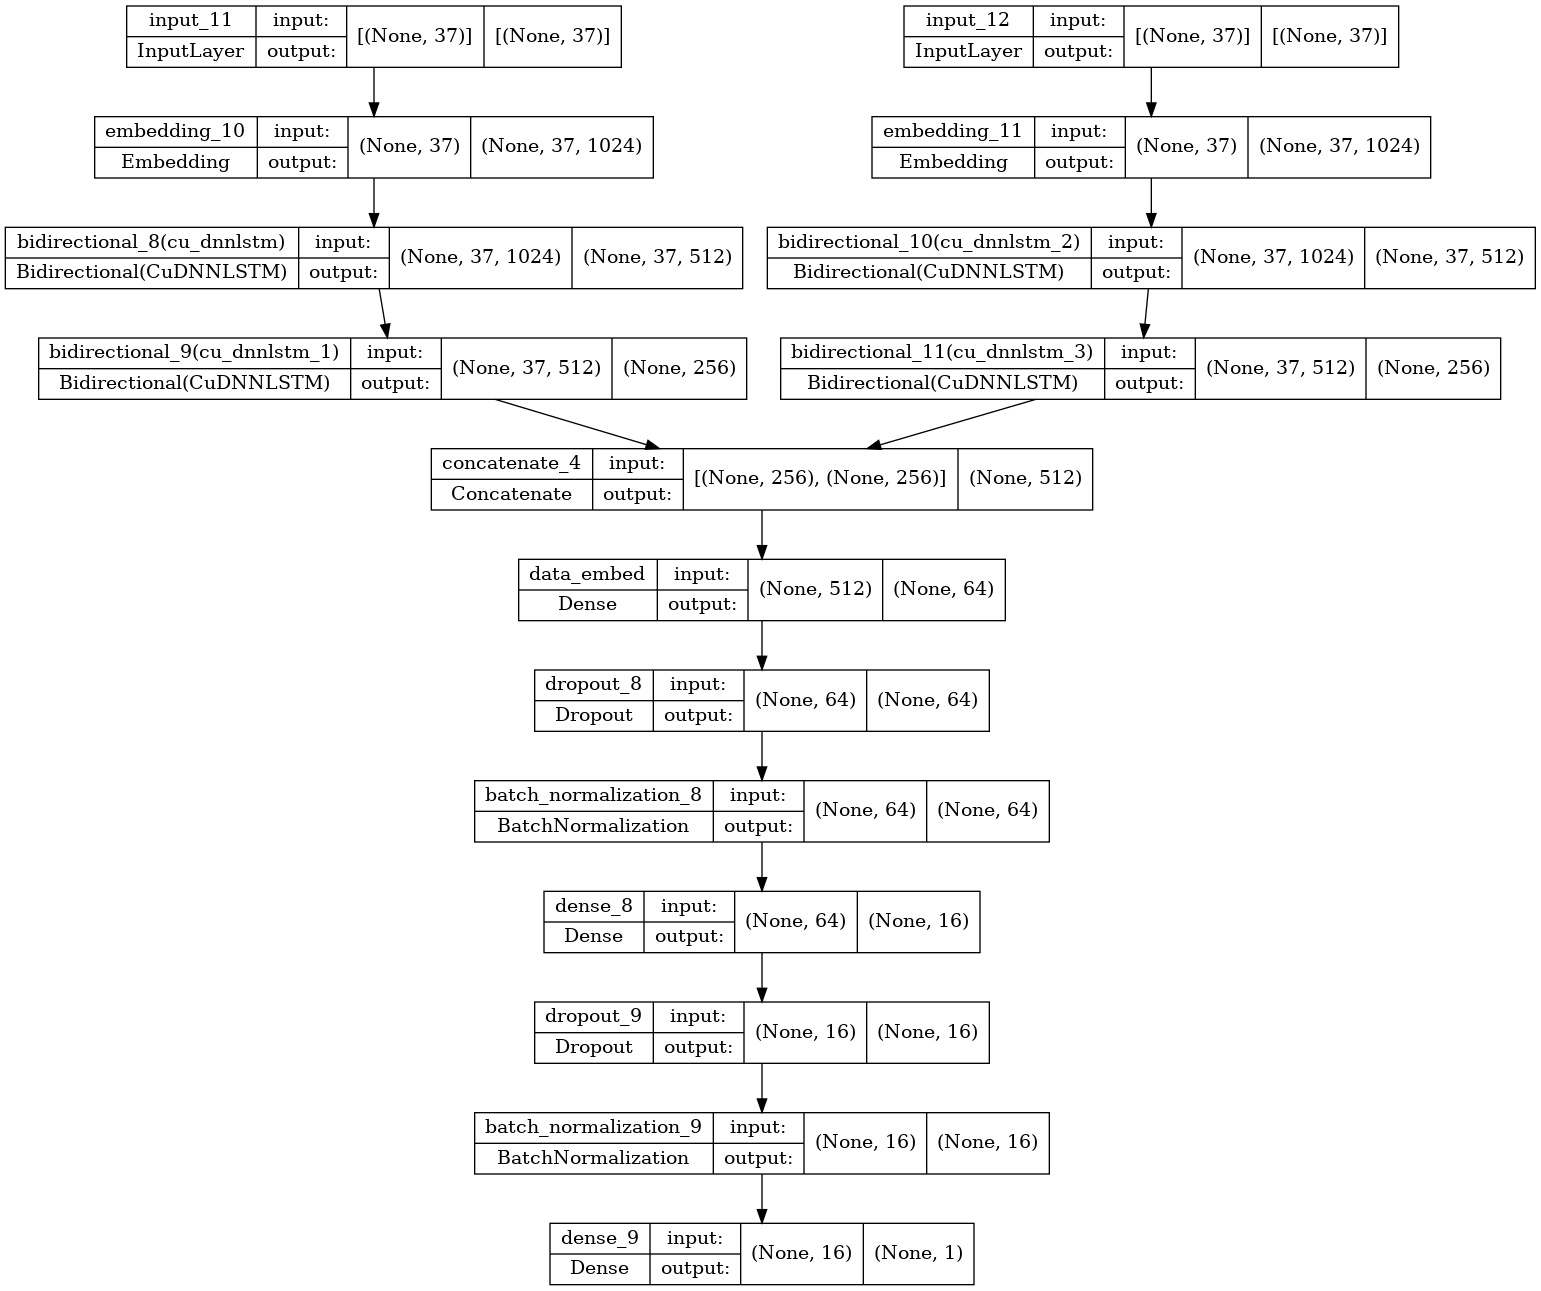

In [63]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='embeddings.png')

In [64]:
gc.collect()

9654

In [ ]:
filepath = "models/saved-model-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

#compile the keras model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[tf.keras.metrics.Recall()])

# Define class weights
# weights = {0:0.2, 1:0.8}

#Early Stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# fit the keras model on the dataset
history = model.fit([X_train_entity_1.todense(),X_train_entity_2.todense()],y_train,
                    epochs=5, 
                    batch_size=128,
                    verbose=1,
                    shuffle=True,
                    callbacks=[callback])


Epoch 1/5


2022-09-17 07:01:26.880518: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


38516/38516 [==============================] - 2846s 74ms/step - loss: 0.2870 - recall_4: 0.8273
Epoch 2/5
 1797/38516 [>.............................] - ETA: 45:15 - loss: 0.2264 - recall_4: 0.8937

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



24436/38516 [==================>...........] - ETA: 17:20 - loss: 0.2247 - recall_4: 0.8948

In [67]:
# evaluate the keras model
_, accuracy = model.evaluate([X_test_entity_1.todense(),X_test_entity_2.todense()], np.array(y_test), verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 90.95


In [71]:
yhat = model.predict([X_test_entity_1.todense(),X_test_entity_2.todense()])
# evaluate the ROC AUC of the predictions
score = roc_auc_score(y_test, yhat)
print('ROC AUC: %.3f' % score)

ROC AUC: 0.980


In [78]:
y_hat = (yhat>0.5).astype('int32')


from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95   1248602
           1       0.94      0.91      0.93    864252

    accuracy                           0.94   2112854
   macro avg       0.94      0.94      0.94   2112854
weighted avg       0.94      0.94      0.94   2112854



In [70]:
gc.collect()

294858

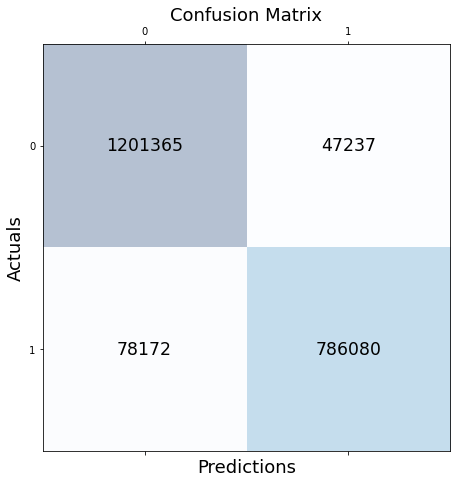

In [77]:
import matplotlib.pyplot as plt
# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_test, y_hat)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [74]:
pip install pretty_confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 77.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 56.4 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=b9384f2e55fea16a512362497eb4bdaa9eb2d4944f1ddc66ca6f6725f627b74a
  Stored in directory: /home/jupyter/.cache/pip/wheels/46/ef/c3/157e41